
--- STRUCTURAL DESIGN RESULTS ---
UDL on beam: 19.50 kN/m
Max Bending Moment: 87.75 kNm
Max Shear Force: 58.50 kN
Required Flexural Steel Area: 531.92 mm²
Use 3 bars of 16 mm dia
Shear Check: OK
Column Load: 780.00 kN | Column Design: Safe


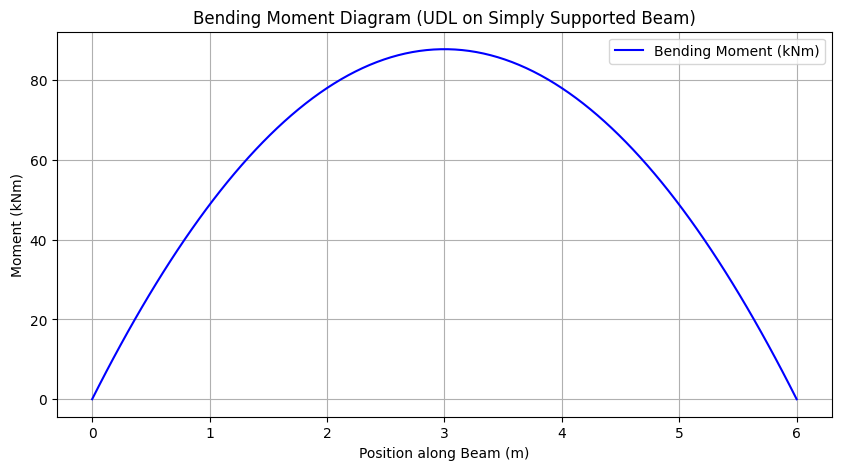

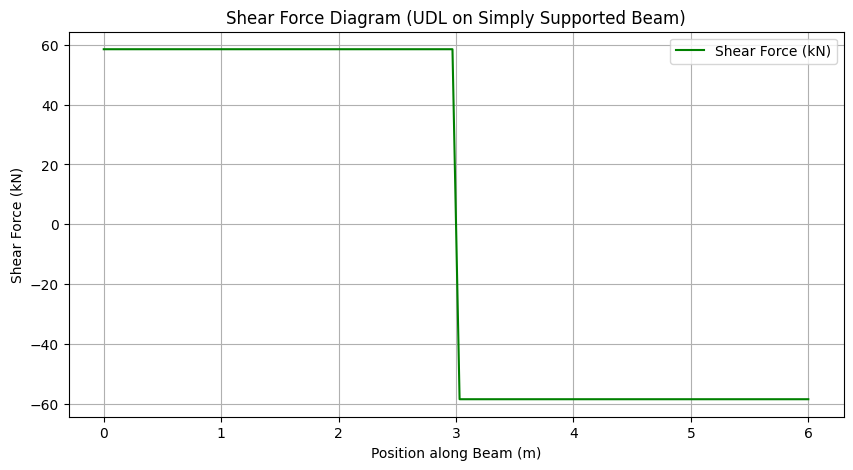

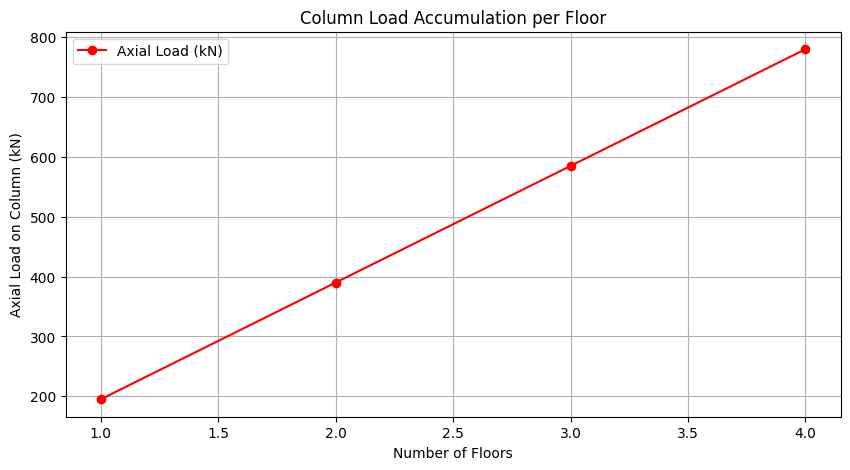

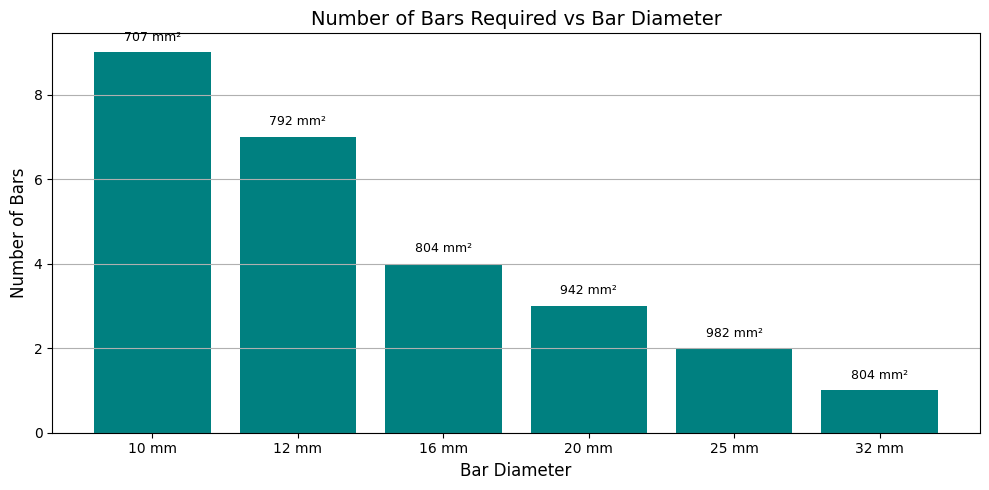

In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np

# --- Building Parameters ---
floors = 4  # G+3
floor_height = 3  # meters
span_m = 6  # typical beam span
trib_width_m = 3  # effective slab width per beam
bay_width = 5  # spacing between columns

# --- Load Data (kN/m2) ---
DL = 4.0  # dead load from slab and finishes
LL = 2.5  # live load

# --- Material Properties ---
fck = 25  # MPa
fy = 500  # MPa
gamma_c = 1.5
gamma_s = 1.15

# --- Beam Dimensions ---
b_beam = 300  # mm
d_beam = 500  # mm
cover = 25  # mm
phi = 16  # bar dia

# --- Column Dimensions ---
b_col = 300  # mm
D_col = 500  # mm

# --- Load Calculation ---
def calculate_udl():
    total_load = (DL + LL) * trib_width_m  # kN/m
    return total_load

def calculate_bm_shear(w, L):
    BM = (w * L ** 2) / 8  # kNm
    V = (w * L) / 2        # kN
    return BM, V

def beam_flexural_design(Mu_kNm):
    Mu = Mu_kNm * 1e6  # Nmm
    d = d_beam - cover
    xu_lim = 0.48 * d  # For Fe500
    Ru = 4.6 * fck * b_beam * xu_lim * (d - 0.42 * xu_lim)
    if Mu <= Ru:
        Ast = Mu / (0.87 * fy * (d - 0.42 * xu_lim))
        return Ast
    else:
        raise ValueError("Section unsafe! Increase depth or width.")

def beam_shear_design(Vu_kN):
    tau_c = 0.48  # From IS 456 Table for M25 and low %steel
    Vu = Vu_kN * 1e3  # N
    tau_v = Vu / (b_beam * d_beam)
    if tau_v <= tau_c * 1e6:
        return "OK"
    else:
        return "Provide shear reinforcement"

def column_design(Pu_kN, Mu_kNm):
    Pu = Pu_kN * 1e3  # N
    Mu = Mu_kNm * 1e6  # Nmm
    Ac = b_col * D_col  # mm2
    Puz = 0.45 * fck * Ac + 0.75 * 0.87 * fy * 0.02 * Ac  # assume 2% steel
    if Pu < 0.65 * Puz:
        return "Safe"
    else:
        return "Increase size or steel %"

# --- Structural Calculations ---
w = calculate_udl()
BM, V = calculate_bm_shear(w, span_m)
Ast = beam_flexural_design(BM)
shear_status = beam_shear_design(V)

floor_load = (DL + LL) * span_m * bay_width  # kN per floor
total_col_load = floor_load * floors
Mu_col = 50  # assumed
col_status = column_design(total_col_load, Mu_col)

# --- Output Results ---
print("\n--- STRUCTURAL DESIGN RESULTS ---")
print(f"UDL on beam: {w:.2f} kN/m")
print(f"Max Bending Moment: {BM:.2f} kNm")
print(f"Max Shear Force: {V:.2f} kN")
print(f"Required Flexural Steel Area: {Ast:.2f} mm²")
print(f"Use {math.ceil(Ast / (math.pi * phi**2 / 4))} bars of {phi} mm dia")
print(f"Shear Check: {shear_status}")
print(f"Column Load: {total_col_load:.2f} kN | Column Design: {col_status}")

# --- Graph 1: Bending Moment Diagram ---
x = np.linspace(0, span_m, 100)
moment = (w * x * (span_m - x)) / 2

plt.figure(figsize=(10, 5))
plt.plot(x, moment, color='blue', label='Bending Moment (kNm)')
plt.title('Bending Moment Diagram (UDL on Simply Supported Beam)')
plt.xlabel('Position along Beam (m)')
plt.ylabel('Moment (kNm)')
plt.grid(True)
plt.legend()
plt.show()

# --- Graph 2: Shear Force Diagram ---
shear = np.where(x < span_m / 2, w * span_m / 2, -w * span_m / 2)

plt.figure(figsize=(10, 5))
plt.plot(x, shear, color='green', label='Shear Force (kN)')
plt.title('Shear Force Diagram (UDL on Simply Supported Beam)')
plt.xlabel('Position along Beam (m)')
plt.ylabel('Shear Force (kN)')
plt.grid(True)
plt.legend()
plt.show()

# --- Graph 3: Column Load Accumulation ---
floor_levels = np.arange(1, floors + 1)
column_loads = floor_levels * floor_load

plt.figure(figsize=(10, 5))
plt.plot(floor_levels, column_loads, marker='o', color='red', label='Axial Load (kN)')
plt.title('Column Load Accumulation per Floor')
plt.xlabel('Number of Floors')
plt.ylabel('Axial Load on Column (kN)')
plt.grid(True)
plt.legend()
plt.show()
import matplotlib.pyplot as plt
import math

# Required steel area from beam flexural design (example)
Ast_required = 701.62  # mm²

# Available bar diameters (mm)
available_diameters = [10, 12, 16, 20, 25, 32]

# Calculate number of bars, area per bar, and total provided area
bar_data = []
for dia in available_diameters:
    area_bar = (math.pi / 4) * dia**2
    num_bars = math.ceil(Ast_required / area_bar)
    total_Ast = num_bars * area_bar
    bar_data.append((dia, area_bar, num_bars, total_Ast))

# Extract data for plotting
diameters = [f"{x[0]} mm" for x in bar_data]
bars_needed = [x[2] for x in bar_data]
provided_areas = [x[3] for x in bar_data]

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(diameters, bars_needed, color='teal')
plt.title("Number of Bars Required vs Bar Diameter", fontsize=14)
plt.xlabel("Bar Diameter", fontsize=12)
plt.ylabel("Number of Bars", fontsize=12)
plt.grid(axis='y')

# Annotate each bar with provided area
for bar, area in zip(bars, provided_areas):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.2,
             f"{area:.0f} mm²", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


